## US Census Data - Its Association with Income and Other Related Issues 

### 0. Library and data loading

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

import sklearn
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%matplotlib inline
csv_clean = pd.read_csv('census.csv')

Populating the interactive namespace from numpy and matplotlib


### 1. Preprocessisng

In [2]:
csv_clean = csv_clean.dropna()
csv_clean.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Remove instances with missing values

In [3]:
csv_clean = csv_clean[csv_clean.occupation != '?']

#### Group countries into world regions

In [4]:
csv_clean['native_country_numeric'] = csv_clean['native.country'].map({'United-States':0,
'Mexico':1,
'Philippines':3,
'Germany':2,
'Canada':0,
'Puerto-Rico':1,
'El-Salvador':1,
'India':3,
'Cuba':1,
'England':2,
'Jamaica':2,
'South':3,
'China':3,
'Italy':2,
'Dominican-Republic':1,
'Vietnam':3,
'Guatemala':1,
'Japan':3,
'Poland':2,
'Columbia':1,
'Taiwan':3,
'Haiti':3,
'Iran':4,
'Portugal':2,
'Nicaragua':1,
'Peru':1,
'France':2,
'Greece':2,
'Ecuador':1,
'Ireland':2,
'Hong':3,
'Trinadad&Tobago':1,
'Cambodia':3,
'Laos':3,
'Thailand':3,
'Yugoslavia':2,
'Outlying-US(Guam-USVI-etc)':4,
'Honduras':1,
'Hungary':2,
'Scotland':2,
'Holand-Netherlands':2,
'?':4}, na_action='ignore')

#### Turn categorical features into numeric values

In [5]:
csv_clean['workclass_numeric'] = csv_clean.workclass.map({'Private':0, 'Self-emp-not-inc':1, 'Self-emp-inc':2, 'Federal-gov':3, 'Local-gov':4, 'State-gov':5, 'Without-pay':6, 'Never-worked':7})
csv_clean['marital_numeric'] = csv_clean['marital.status'].map({'Never-married':0, 'Divorced':1, 'Separated':2, 'Widowed':3, 'Married-spouse-absent':4, 'Married-civ-spouse':5, 'Married-AF-spouse':5})
csv_clean['race_numeric'] = csv_clean.race.map({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3, 'Other':4})
csv_clean['rel_numeric'] = csv_clean.relationship.map({'Not-in-family':0, 'Unmarried':0, 'Other-relative':0, 'Own-child':1, 'Husband':1, 'Wife':1})
csv_clean['sex_numeric'] = csv_clean.sex.map({'Male':0, 'Female':1})
csv_clean['income_over_50K'] = np.where(csv_clean.income == '<=50K', 0, 1)
csv_clean[:10]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,hours.per.week,native.country,income,native_country_numeric,workclass_numeric,marital_numeric,race_numeric,rel_numeric,sex_numeric,income_over_50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,18,United-States,<=50K,0,0,3,0,0,1,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,40,United-States,<=50K,0,0,1,0,0,1,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,40,United-States,<=50K,0,0,2,0,1,1,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,45,United-States,<=50K,0,0,1,0,0,1,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,40,United-States,<=50K,0,0,2,0,0,0,0
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,...,20,United-States,>50K,0,5,0,0,0,1,1
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,...,40,United-States,<=50K,0,3,1,0,0,1,0
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,...,60,?,>50K,4,0,0,0,0,0,1
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,...,35,United-States,>50K,0,0,1,1,0,1,1
11,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,...,45,United-States,>50K,0,1,0,0,0,0,1


In [6]:
csv_clean['income'].value_counts()

<=50K    23068
>50K      7650
Name: income, dtype: int64

In [7]:
X = csv_clean[['workclass_numeric', 'education.num', 'marital_numeric', 'race_numeric', 'sex_numeric', 'rel_numeric', 'capital.gain', 'capital.loss', 'native_country_numeric']]
y = csv_clean.income_over_50K

### 2. Pre-classification processing and preparation steps

#### Extra Trees feature selection

[ 0.04543164  0.2320909   0.28974058  0.01716671  0.01944093  0.08035393
  0.21355006  0.08337709  0.01884817]
0.289740580546


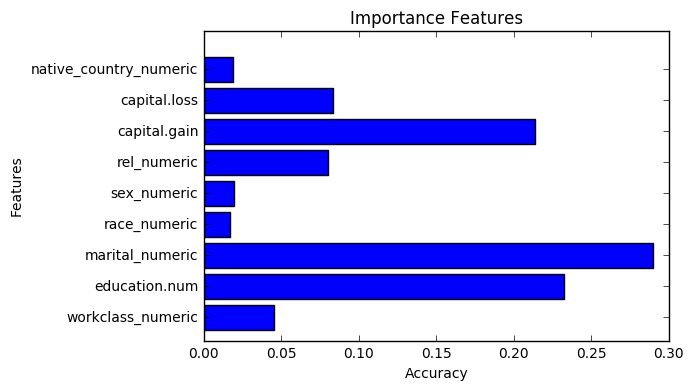

In [8]:
extra_tree = ExtraTreesClassifier()
extra_tree.fit(X, y)
fea_imp = extra_tree.feature_importances_
print(fea_imp)
max_fea_imp = max(fea_imp)
print(max_fea_imp)

pos = np.arange(9) + 0.75
plt.barh(pos, fea_imp, align='center')
plt.yticks(pos, ('workclass_numeric', 'education.num', 'marital_numeric', 'race_numeric', 'sex_numeric', 'rel_numeric', 'capital.gain', 'capital.loss', 'native_country_numeric'))
plt.xlabel('Accuracy')
plt.ylabel('Features')
plt.title('Importance Features')
plt.grid(False)

In [9]:
X = csv_clean[['education.num', 'marital_numeric', 'capital.gain']]
y = csv_clean.income_over_50K

#### Smote initialization

In [10]:
from imblearn.over_sampling import SMOTE
rseed=100
sm = SMOTE(random_state=rseed)
    
X = pd.DataFrame(X.values, columns=X.columns)
y = pd.Series(y.values, name='income_over_50k')

#### K-Fold cross-validation

In [11]:
kf = StratifiedKFold(n_splits=5, random_state=rseed, shuffle=True)
kf.get_n_splits(X)

5

#### Validation helper functions

In [12]:
import itertools
import matplotlib.pyplot as plt

# plot_confusion_matrix taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
def crossval_report(X, y, clf, kf):
    y_predicted_overall = None
    y_test_overall = None
    for train_index, test_index in  kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        if y_predicted_overall is None:
            y_predicted_overall = y_predicted
            y_test_overall = y_test
        else: 
            y_predicted_overall = np.concatenate([y_predicted_overall, y_predicted])
            y_test_overall = np.concatenate([y_test_overall, y_test])
    
    print (classification_report(y_test_overall, y_predicted_overall, digits=3))
    confusion_matrix(y_test_overall, y_predicted_overall)

In [14]:
# Like crossval_report but with a smote option included, if desired
def crossval_report2(X, y, clf, kf, use_smote=False):
    y_predicted_overall = None
    y_test_overall = None

    for train_index, test_index in  kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if use_smote:
            X_train, y_train = sm.fit_sample(X_train, y_train)
        X_train = pd.DataFrame(X_train, columns=X.columns)
        y_train = pd.Series(y_train, name='income_over_50K')

        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        if y_predicted_overall is None:
            y_predicted_overall = y_predicted
            y_test_overall = y_test
        else: 
            y_predicted_overall = np.concatenate([y_predicted_overall, y_predicted])
            y_test_overall = np.concatenate([y_test_overall, y_test])
    
    print (classification_report(y_test_overall, y_predicted_overall, digits=3))
    cm = confusion_matrix(y_test_overall, y_predicted_overall)
    plot_confusion_matrix(cm, classes=["<=50K", ">50K"], title='Confusion matrix')
    print(sklearn.metrics.accuracy_score(y_test_overall, y_predicted_overall))

### 3. Classification and other analysis

#### Random Forest

[ 0.84082031  0.84358724  0.84244792  0.84600358  0.84681752]
Accuracy: 0.84 (+/- 0.00)
[ 0.84065755  0.84521484  0.8429362   0.84779424  0.84779424]
Accuracy: 0.84 (+/- 0.01)
[ 0.8421224   0.84440104  0.8421224   0.84795702  0.84844538]
Accuracy: 0.85 (+/- 0.01)
[ 0.84179688  0.84472656  0.8429362   0.84877096  0.84860817]
Accuracy: 0.85 (+/- 0.01)
[ 0.8429362   0.84488932  0.84423828  0.84844538  0.8482826 ]
Accuracy: 0.85 (+/- 0.00)
[ 0.84277344  0.84488932  0.84261068  0.8482826   0.84844538]
Accuracy: 0.85 (+/- 0.01)
[ 0.8429362   0.84488932  0.84277344  0.84811981  0.84877096]
Accuracy: 0.85 (+/- 0.01)
[ 0.84244792  0.84505208  0.8429362   0.84730588  0.84893375]
Accuracy: 0.85 (+/- 0.00)
[ 0.8421224   0.84505208  0.84375     0.84844538  0.84893375]
Accuracy: 0.85 (+/- 0.01)
[ 0.8429362   0.8453776   0.8429362   0.84811981  0.84860817]
Accuracy: 0.85 (+/- 0.00)
[ 0.84244792  0.84521484  0.84261068  0.84909653  0.84893375]
Accuracy: 0.85 (+/- 0.01)
[ 0.8429362   0.84440104  0.8421

array([ 0.84393531,  0.84487941,  0.84500965,  0.84536775,  0.84575836,
        0.84540028,  0.84549795,  0.84533516,  0.84566072,  0.8455956 ,
        0.84566074,  0.84543287,  0.84556308,  0.84553051,  0.8459537 ,
        0.8454654 ,  0.84562817,  0.8454654 ,  0.84575838,  0.84566072,
        0.84556306,  0.84569328,  0.84569327,  0.84562818,  0.84543285])

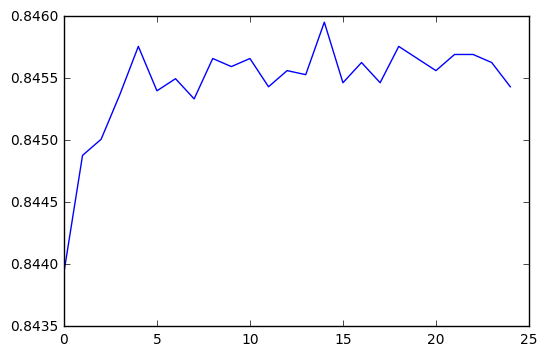

In [15]:
trees = range(25)
accuracy = np.zeros(25)
#accuracy = np.zeros(25)
for i in range(len(trees)):
    clf = RandomForestClassifier(n_estimators = i + 1)
    scores = cross_val_score(clf, X, y, cv=kf)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    accuracy[i] = scores.mean()
plt.cla()
plt.plot(trees, accuracy)
accuracy

[ 0.84277344  0.84472656  0.84228516  0.84860817  0.84893375]
Accuracy: 0.85 (+/- 0.01)
Without SMOTE
             precision    recall  f1-score   support

          0      0.860     0.949     0.902     23068
          1      0.777     0.532     0.632      7650

avg / total      0.839     0.846     0.835     30718

Confusion matrix, without normalization
[[21901  1167]
 [ 3578  4072]]


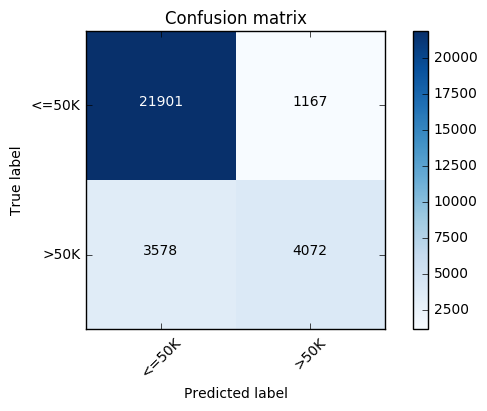

0.845530307963
With SMOTE
             precision    recall  f1-score   support

          0      0.953     0.720     0.821     23068
          1      0.514     0.894     0.653      7650

avg / total      0.844     0.763     0.779     30718

Confusion matrix, without normalization
[[16614  6454]
 [  811  6839]]


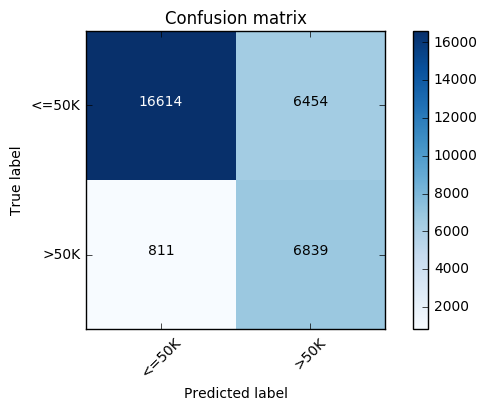

0.763493717039


In [16]:
clf = RandomForestClassifier(n_estimators=25)

scores = cross_val_score(clf, X, y, cv=kf)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Without SMOTE")
crossval_report2(X, y, clf, kf, use_smote=False)
print("With SMOTE")
crossval_report2(X, y, clf, kf, use_smote=True)

#### Logistic Regression

[ 0.82861328  0.83382161  0.83317057  0.83135276  0.83477128]
Accuracy: 0.83 (+/- 0.00)
Without SMOTE
             precision    recall  f1-score   support

          0      0.861     0.927     0.892     23068
          1      0.712     0.548     0.619      7650

avg / total      0.824     0.832     0.824     30718

Confusion matrix, without normalization
[[21376  1692]
 [ 3458  4192]]


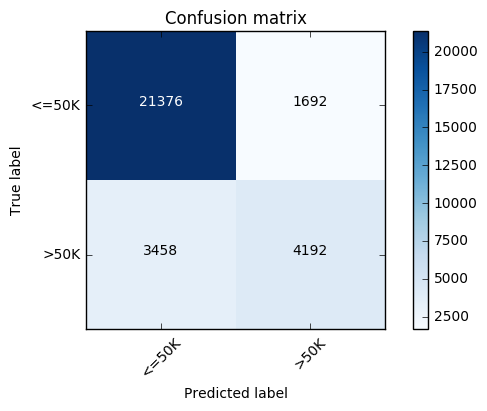

0.83234585585
With SMOTE
             precision    recall  f1-score   support

          0      0.949     0.689     0.799     23068
          1      0.487     0.889     0.629      7650

avg / total      0.834     0.739     0.757     30718

Confusion matrix, without normalization
[[15905  7163]
 [  852  6798]]


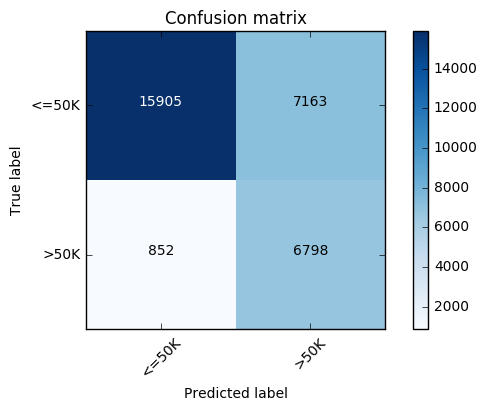

0.739078064978


In [17]:
lr = LogisticRegression()
#lr = lr.fit(X_train,y_train)
#predictions = lr.predict(X_test)
#sklearn.metrics.confusion_matrix(y_test,predictions)
scores = cross_val_score(lr, X, y, cv=kf)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Without SMOTE")
crossval_report2(X, y, lr, kf, use_smote=False)
print("With SMOTE")
crossval_report2(X, y, lr, kf, use_smote=True)

#### Histograms

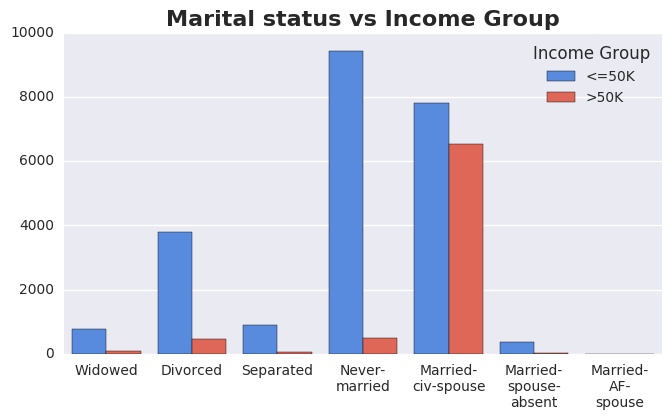

In [18]:
import matplotlib.gridspec as gridspec
import seaborn as sns
gs = gridspec.GridSpec(7, 2)
plt.figure(figsize=(17,34))

#Marital status vs Income Group
ax1 = plt.subplot(gs[0])
sns.countplot(csv_clean['marital.status'], hue=csv_clean['income'], ax=ax1, palette=['#4286f4', '#f45641'])
ax1.set_ylabel(""), ax1.set_xlabel("")
ax1.set_xticklabels(['Widowed', 'Divorced', 'Separated', 'Never-\nmarried',
                     'Married-\nciv-spouse', 'Married-\nspouse-\nabsent',
                     'Married-\nAF-\nspouse'])
ax1.legend(title="Income Group")
ax1.set_title("Marital status vs Income Group", fontsize=16, fontweight='bold')

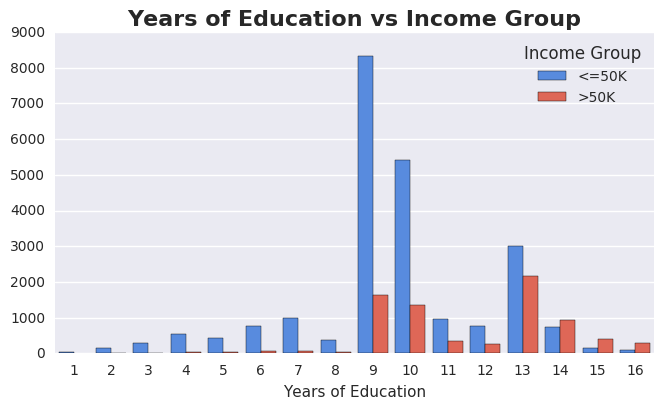

In [19]:
#Education num vs Income Group
gs = gridspec.GridSpec(7,2)
plt.figure(figsize=(17,34))
ax2 = plt.subplot(gs[0])
sns.countplot(csv_clean['education.num'], hue=csv_clean['income'], ax=ax2, palette=['#4286f4', '#f45641'])
ax2.set_xlabel('Years of Education'), ax2.set_ylabel("")
ax2.set_title("Years of Education vs Income Group", fontsize=16, fontweight='bold')
ax2.legend(title="Income Group")

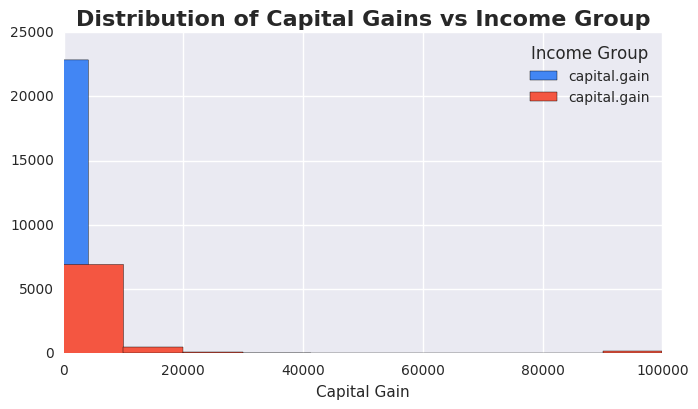

In [20]:
#Capital Gain vs Income Group
gs = gridspec.GridSpec(7,2)
plt.figure(figsize=(17,34))
ax3 = plt.subplot(gs[0])
ax3.hist(csv_clean.loc[csv_clean['income']=="<=50K", 'capital.gain'], color="#4286f4")
ax3.hist(csv_clean.loc[csv_clean['income']==">50K", 'capital.gain'], color="#f45641")
ax3.set_ylabel(""), ax3.set_xlabel("Capital Gain")
ax3.legend(title="Income Group")
ax3.set_title('Distribution of Capital Gains vs Income Group', fontsize=16, fontweight='bold')

#### Decision Tree

[ 0.8375651   0.83984375  0.83707682  0.84144555  0.84405014]
Accuracy: 0.84 (+/- 0.01)
Without SMOTE
             precision    recall  f1-score   support

          0      0.855     0.948     0.899     23068
          1      0.767     0.514     0.615      7650

avg / total      0.833     0.840     0.828     30718

Confusion matrix, without normalization
[[21872  1196]
 [ 3719  3931]]


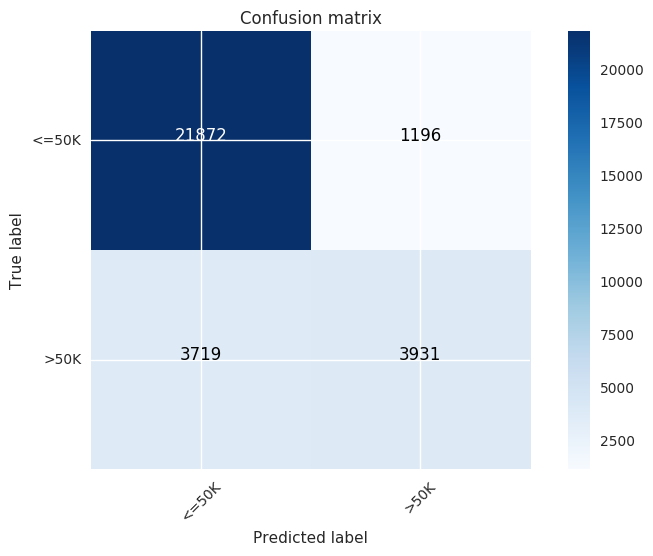

0.839996093496
With SMOTE
             precision    recall  f1-score   support

          0      0.925     0.739     0.821     23068
          1      0.510     0.819     0.628      7650

avg / total      0.821     0.759     0.773     30718

Confusion matrix, without normalization
[[17043  6025]
 [ 1387  6263]]


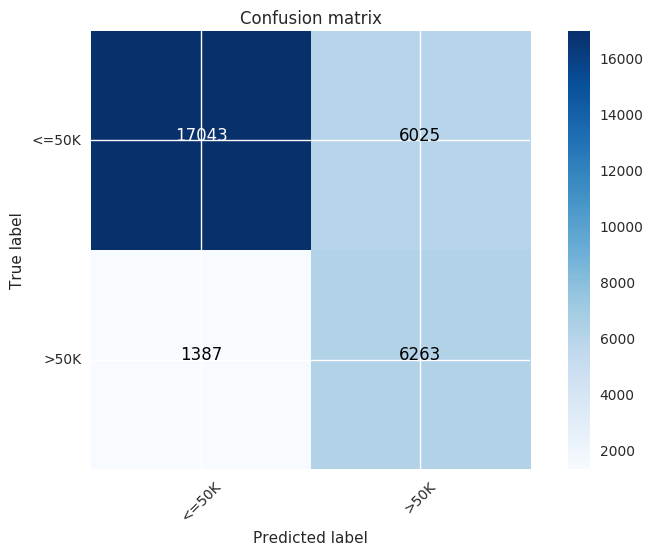

0.758708249235


In [21]:
from sklearn import tree

dectree = tree.DecisionTreeClassifier(max_features=3, random_state=rseed, max_depth=3)
dectree.fit(X, y)
scores = cross_val_score(dectree, X, y, cv=kf)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Without SMOTE")
crossval_report2(X, y, dectree, kf, use_smote=False)
print("With SMOTE")
crossval_report2(X, y, dectree, kf, use_smote=True)

In [22]:
print(X.columns)
print(dectree.feature_importances_)

Index(['education.num', 'marital_numeric', 'capital.gain'], dtype='object')
[ 0.17230314  0.6506866   0.17701026]


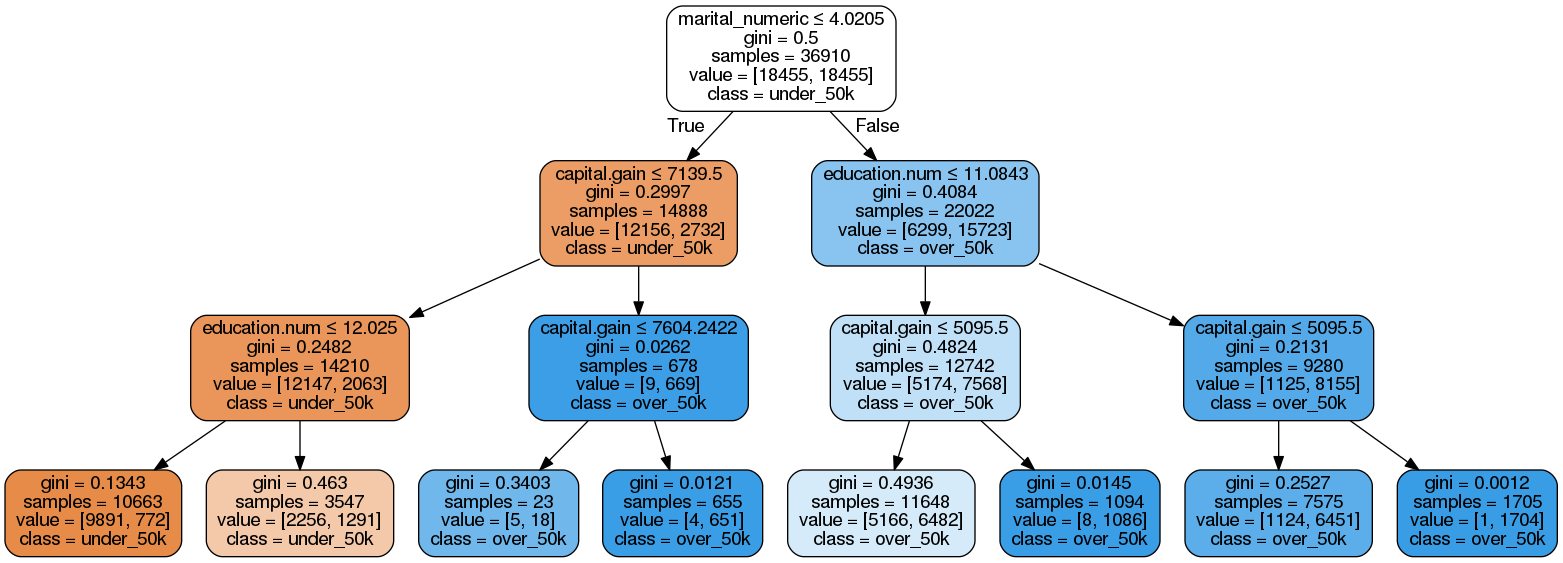

In [23]:
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(dectree, out_file=None, 
                         feature_names=X.columns,  
                         class_names=['under_50k', 'over_50k'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())   

#### k-NN

Using weights=uniform
[ 0.82486979  0.83072917  0.76204427  0.84877096  0.8333062 ]
Accuracy: 0.82 (+/- 0.06)
Without SMOTE
             precision    recall  f1-score   support

          0      0.875     0.886     0.881     23068
          1      0.644     0.620     0.632      7650

avg / total      0.818     0.820     0.819     30718

Confusion matrix, without normalization
[[20447  2621]
 [ 2910  4740]]


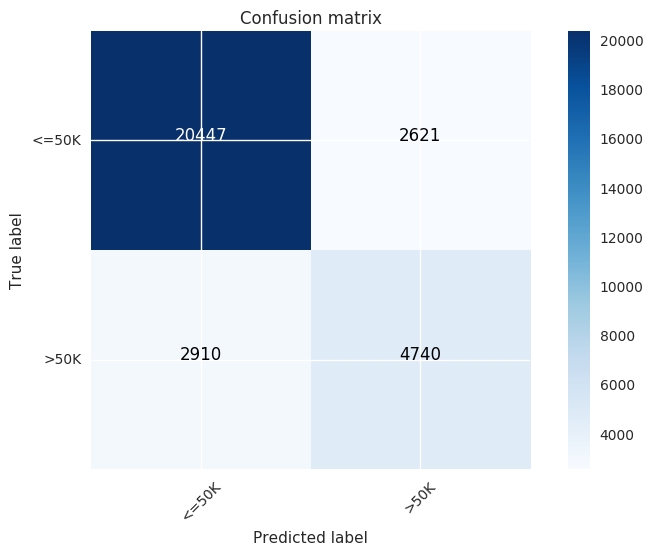

0.819942704603
With SMOTE
             precision    recall  f1-score   support

          0      0.875     0.874     0.875     23068
          1      0.621     0.624     0.623      7650

avg / total      0.812     0.812     0.812     30718

Confusion matrix, without normalization
[[20161  2907]
 [ 2879  4771]]


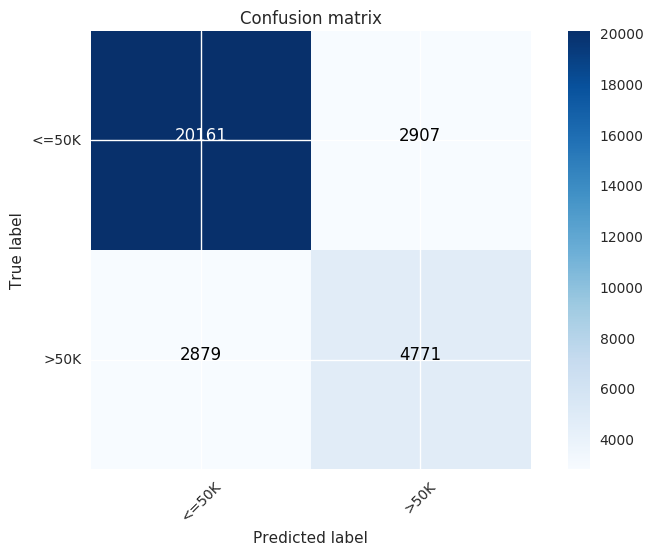

0.811641382903
Using weights=distance
[ 0.82584635  0.83089193  0.76285807  0.84991047  0.83509686]
Accuracy: 0.82 (+/- 0.06)
Without SMOTE
             precision    recall  f1-score   support

          0      0.876     0.887     0.881     23068
          1      0.646     0.622     0.634      7650

avg / total      0.819     0.821     0.820     30718

Confusion matrix, without normalization
[[20460  2608]
 [ 2893  4757]]


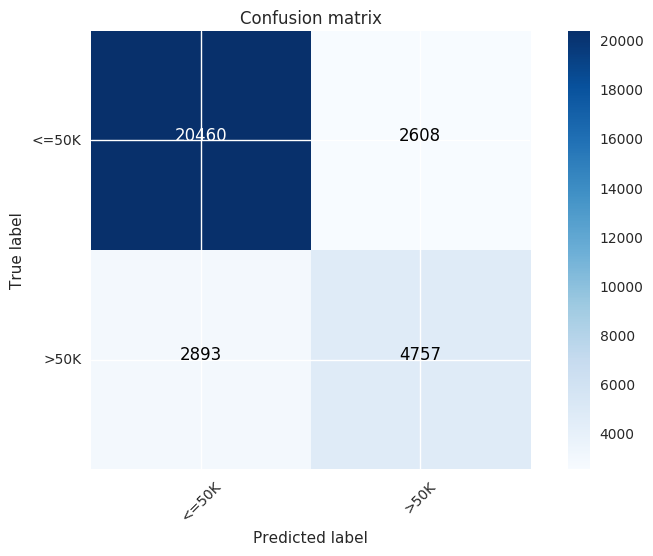

0.820919330686
With SMOTE
             precision    recall  f1-score   support

          0      0.875     0.875     0.875     23068
          1      0.623     0.624     0.623      7650

avg / total      0.812     0.812     0.812     30718

Confusion matrix, without normalization
[[20178  2890]
 [ 2876  4774]]


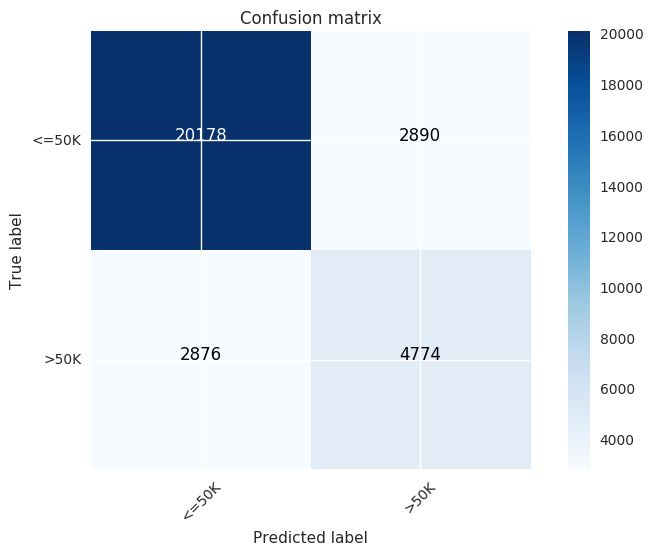

0.812292466957


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

from sklearn import model_selection

n_neighbors = 7
    
for weights in ['uniform', 'distance']:
    print("Using weights=" + weights)
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    scores = cross_val_score(clf, X, y, cv=kf)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Without SMOTE")
    crossval_report2(X, y, clf, kf, use_smote=False)
    print("With SMOTE")
    crossval_report2(X, y, clf, kf, use_smote=True)